# Twitter post classification - Offensive or Not

## Introduction
As offensive content has become pervasive in Social media platforms like Twitter, our task is to develop a model that can identify potentially offensive Tweets/Post. We are going to use the OLID dataset available at https://scholar.harvard.edu/malmasi/olid to classify text, determining if a twitter's post is offensive or not. Therefore we will be using binary classification techniques. We tranform the posts into numerical data by using pre-trained word embeddings called fasttext (https://fasttext.cc/) which is a library for efficient learning of word representations.

**Lets import libraries**

In [3]:
%matplotlib inline
import wget
import zipfile
import os
import pandas as pd
import numpy as np
from itertools import *
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.base import TransformerMixin
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from preprocessor_arc import Arc_preprocessor
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import webtext
from nltk.collocations import BigramCollocationFinder
from nltk.collocations import TrigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from sklearn.preprocessing import OneHotEncoder
import string
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler

In [5]:
if not os.path.exists('data'):
    os.makedirs('data', mode=0o777)
if not os.path.exists('embeddings'):
    os.makedirs('embeddings', mode=0o777)
    

**Declare Paths**

In [7]:
DATASET_URL = 'https://drive.google.com/uc?export=download&id=1E3GpaEdlB-o0odErsK5eYW7fD44bW72J'
DATASET_PATH = 'data/OffensEval_dataset.tsv'
EMBEDDING_URL = 'https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip'
EMBEDDING_PATH = 'embeddings/crawl-300d-2M.vec.zip'


**Download dataset**

In [8]:
wget.download(DATASET_URL, DATASET_PATH) 


'data/OffensEval_dataset.tsv'

**Download fasttext embeddings**

In [7]:
wget.download(EMBEDDING_URL, EMBEDDING_PATH)


'embeddings/crawl-300d-2M.vec.zip'

In [12]:
zip_ref = zipfile.ZipFile(EMBEDDING_PATH, 'r')
zip_ref.extractall(os.path.dirname(EMBEDDING_PATH))
zip_ref.close()

Now some setup, defining the transformer that transforms the essay data into word embeddings. This will be done word by word, and then the word vectors will be averaged to find the document mean vector.

**Data Loading and Analysis**

In [143]:
data_df = pd.read_csv(DATASET_PATH, sep='\t',
                        dtype={'tweet': object,  'id': np.int32,
                              'subtask_a': 'category', 'subtask_b': 'category'
                              , 'subtask_c': 'category'})

In [144]:
data_df[['tweet','subtask_a']].head(4)

,tweet,subtask_a
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF


In [145]:
data_df.loc[data_df['subtask_a'] == 'OFF'].tweet.head(4).values

array(['@USER She should ask a few native Americans what their take on this is.',
       '@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL',
       '@USER Someone should\'veTaken" this piece of shit to a volcano. 😂"',
       '@USER Liberals are all Kookoo !!!'], dtype=object)

In [146]:
data_df.loc[data_df['subtask_a'] == 'NOT'].tweet.head(4).values

array(['Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT',
       '@USER @USER Obama wanted liberals &amp; illegals to move into red states',
       '@USER Buy more icecream!!!',
       '@USER @USER @USER It’s not my fault you support gun control'],
      dtype=object)

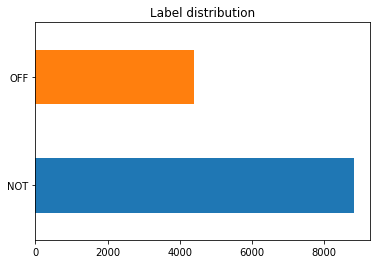

In [147]:
data_df['subtask_a'].value_counts().plot(kind='barh', title='Label distribution')

**Word frequency distrbution - unigram**


In [148]:
arc_obj = Arc_preprocessor()
stopwords = nltk.corpus.stopwords.words('english')

In [149]:
offensive_tweets = data_df.loc[data_df['subtask_a'] == 'OFF'][['tweet']].values[:,0]
off_tok_tweet = [arc_obj.tokenizeRawTweetText(doc.lower()) for doc in offensive_tweets]

In [150]:
ravel_off_tok_tweet = list(chain.from_iterable(off_tok_tweet))

In [151]:
ravel_off_tok_tweet = [word for word in ravel_off_tok_tweet if word not in stopwords and word.isalpha() ]

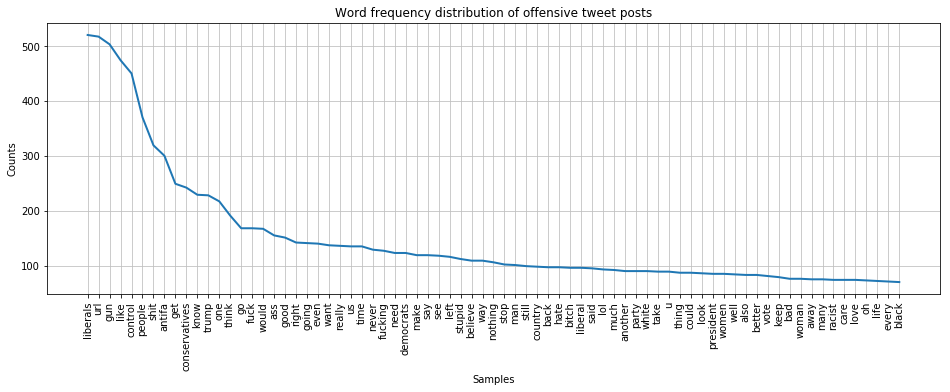

In [152]:
freqdist = nltk.FreqDist(ravel_off_tok_tweet)
plt.figure(figsize=(16,5))
plt.title('Word frequency distribution of offensive tweet posts')
freqdist.plot(75)

In [153]:
not_off_tweets = data_df.loc[data_df['subtask_a'] == 'NOT'][['tweet']].values[:,0]
not_off_tok_tweet = [arc_obj.tokenizeRawTweetText(doc.lower()) for doc in not_off_tweets]

In [154]:
ravel_not_off_tok_tweet = list(chain.from_iterable(not_off_tok_tweet))

In [155]:
ravel_not_off_tok_tweet = [word for word in ravel_not_off_tok_tweet 
                           if word not in stopwords and word.isalpha() ]


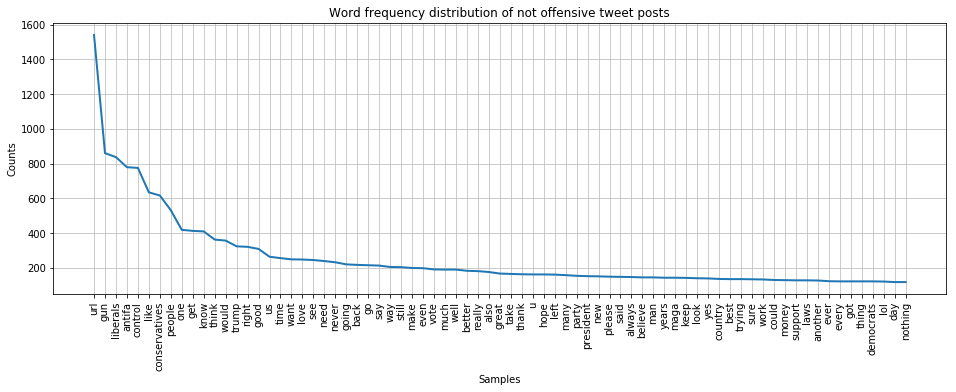

In [156]:
freqdist = nltk.FreqDist(ravel_not_off_tok_tweet)
plt.figure(figsize=(16,5))
plt.title('Word frequency distribution of not offensive tweet posts')
freqdist.plot(75)


**Word frequency distrbution - bigram**

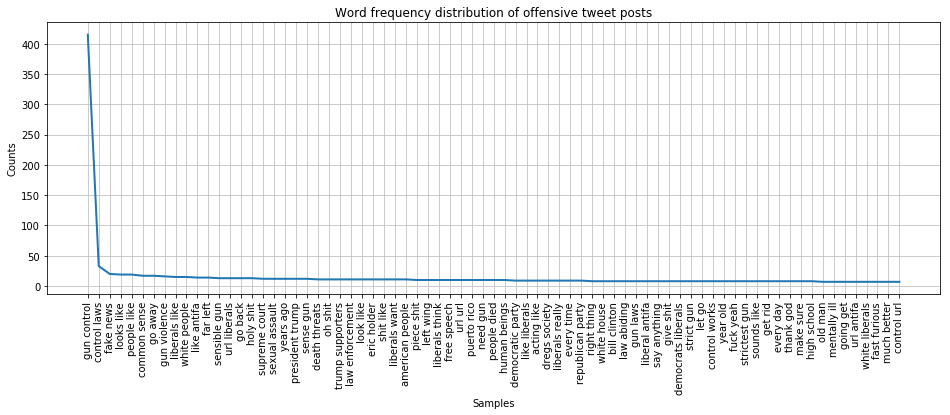

In [157]:
bigrams_offensive_list = list(nltk.bigrams(ravel_off_tok_tweet))
bigrams_offensive_list = [' '.join(x) for x in bigrams_offensive_list]
freqdist = nltk.FreqDist(bigrams_offensive_list)
plt.figure(figsize=(16,5))
plt.title('Word frequency distribution of offensive tweet posts')
freqdist.plot(75)

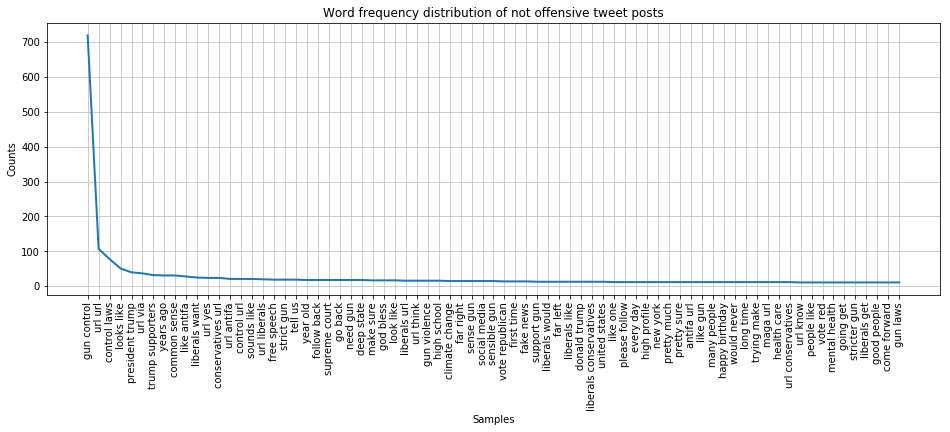

In [158]:
bigrams_not_offensive_list = list(nltk.bigrams(ravel_not_off_tok_tweet))
bigrams_not_offensive_list = [' '.join(x) for x in bigrams_not_offensive_list]
freqdist = nltk.FreqDist(bigrams_not_offensive_list)
plt.figure(figsize=(16,5))
plt.title('Word frequency distribution of not offensive tweet posts')
freqdist.plot(75)

**Word Clouds**


In [159]:
from wordcloud import WordCloud


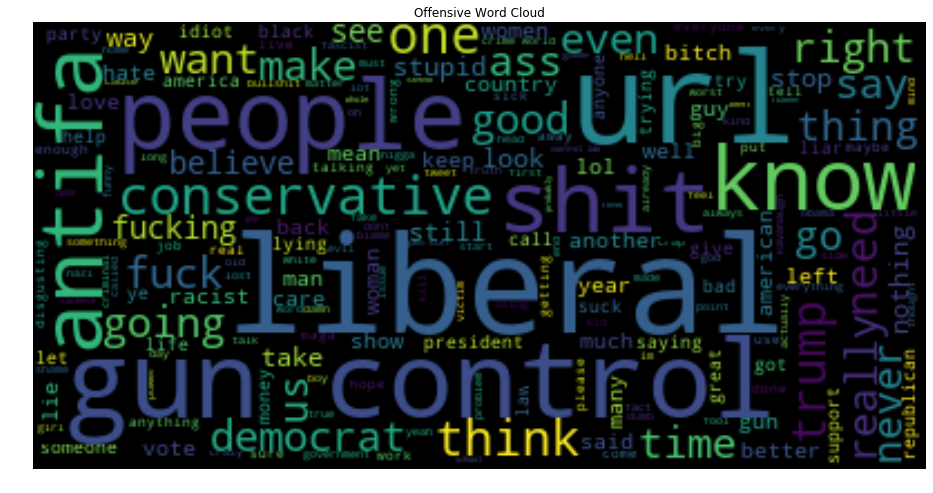

In [160]:
offensive_text = ' '.join(ravel_off_tok_tweet)
wordcloud = WordCloud(max_font_size=60).generate(offensive_text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Offensive Word Cloud")
plt.axis("off")
plt.show()


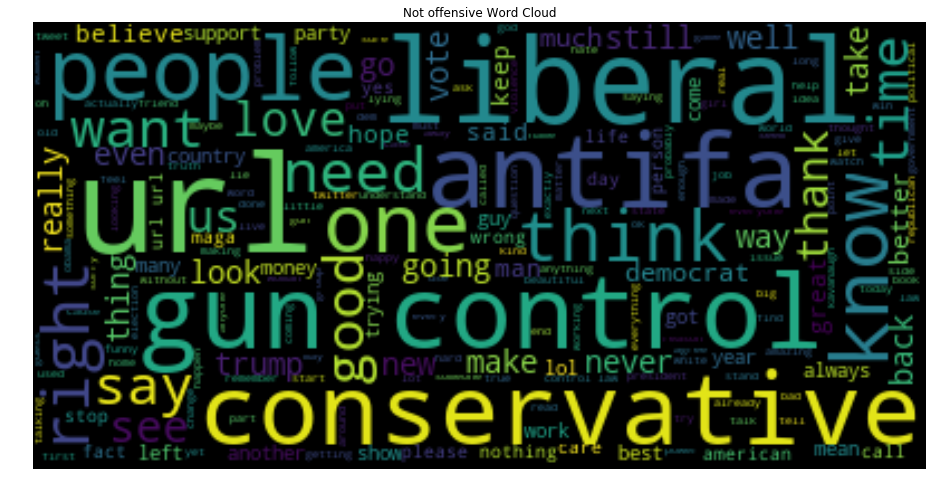

In [161]:
not_offensive_text = ' '.join(ravel_not_off_tok_tweet)
wordcloud = WordCloud(max_font_size=60).generate(not_offensive_text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.title("Not offensive Word Cloud")
plt.axis("off")
plt.show()


**Data Preprocessing and Transformation**

In [162]:
class MeanEmbeddingTransformer(TransformerMixin):
    
    def __init__(self):
        self._vocab, self._E = self._load_words()
        
    
    def _load_words(self):
        E = {}
        vocab = []
        #emb_path = EMBEDDING_PATH.replace('.zip','')
        emb_path = os.path.join(os.path.dirname(EMBEDDING_PATH),'offeneval_subtask_a.vec')
        with open(emb_path, 'r', encoding="utf8") as file:
            for i, line in enumerate(file):
                l = line.split(' ')
                if l[0].isalpha():
                    v = [float(i) for i in l[1:]]
                    E[l[0]] = np.array(v)
                    vocab.append(l[0])
        return np.array(vocab), E            

    
    def _get_word(self, v):
        for i, emb in enumerate(self._E):
            if np.array_equal(emb, v):
                return self._vocab[i]
        return None
    
    def _doc_mean(self, doc):
        word_array = []
        for w in doc:
            if  w.lower().strip() in self._E:
                word_array.append(self._E[w.lower().strip()])
            else:
                word_array.append(np.zeros([len(v) for v in self._E.values()][0]))

        return np.mean(np.array(word_array), axis=0)
                
        #return np.mean(np.array([self._E[w.lower().strip()] for w in doc if w.lower().strip() in self._E else np.zeros([len(v) for v in self._E.values()][0])]), axis=0)
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return np.array([self._doc_mean(doc) for doc in X])
    
    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

In [163]:
def tokenize_and_transform(X, sample_size):
    tweets = X[:,0]
    arc_obj = Arc_preprocessor()
    tok_tweet = [arc_obj.tokenizeRawTweetText(doc.lower()) for doc in tweets[:sample_size]]
    #tok_tweet = [word_tokenize(doc) for doc in tweets[:sample_size]]
    met = MeanEmbeddingTransformer()
    X_transform = met.fit_transform(tok_tweet)
    return X_transform

In [164]:
X = data_df[['tweet']].values
y = data_df['subtask_a'].values

In [165]:
X_transform = tokenize_and_transform(X, 160000)

**Data after transformation**

In [171]:
np.set_printoptions(threshold=5)
for i,tw in enumerate(X):
    print('%s:%s'%(tw[0],np.array(X_transform[i])))
    if i > 3:
        break

@USER She should ask a few native Americans what their take on this is.:[-0.23785868 -0.81432081 -0.59736057 ... -0.76759186  0.74580504
 -1.64158117]
@USER @USER Go home you’re drunk!!! @USER #MAGA #Trump2020 👊🇺🇸👊 URL:[ 0.14161531 -0.55757464  0.42154353 ... -0.27313893  0.64572821
  0.21286828]
Amazon is investigating Chinese employees who are selling internal data to third-party sellers looking for an edge in the competitive marketplace. URL #Amazon #MAGA #KAG #CHINA #TCOT:[ 0.61464088  0.90188339  0.15088314 ...  0.14194924  0.78256637
 -0.93532037]
@USER Someone should'veTaken" this piece of shit to a volcano. 😂":[-0.17469034 -0.18162627  0.95127902 ... -0.94913055  0.21175736
  0.79832478]
@USER @USER Obama wanted liberals &amp; illegals to move into red states:[ 2.5257941  -0.03132355 -0.60718661 ... -2.42689326  0.4544278
  2.67988114]


**Standardize features by removing the mean and scaling to unit variance**

In [167]:
scaler = StandardScaler()
X_transform = scaler.fit_transform(X_transform)

**Get label encodings**

In [168]:
le = LabelEncoder()
y = le.fit_transform(y)

**Data Split into train and test set**

In [169]:
X_train, X_test, y_train, y_test = train_test_split(X_transform,
                                                    y, stratify=y, test_size=0.2, random_state=0)

**Model training and evaluation**

To determine if the dataset is unbalanced we can count the positive and negative cases. The number of positive cases is over two times the number of negative cases, which is very unbalanced, the AUC for the ROC curve or the F1 score would work fine for this dataset, but not regular accuracy.



In [170]:
def plot_roc(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    
def print_scores(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('Precision score: {:3f}'.format(precision_score(y_test, y_pred, average='macro') ))
    print('Recall score: {:3f}'.format(recall_score(y_test, y_pred, average='macro') ))
    print('F1 score: {:3f}'.format(f1_score(y_test, y_pred, average='macro')))
    print('AUC score: {:3f}'.format(roc_auc_score(y_test, y_pred)))
    print('Confusion Metric : %s' %(confusion_matrix(y_test, y_pred)))
    print('Prediction Accuracy: {:3f}'.format(accuracy_score(y_test, y_pred)))

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Precision score: 0.729671
Recall score: 0.685194
F1 score: 0.696542
AUC score: 0.685194
Confusion Metric : [[1573  195]
 [ 457  423]]
Prediction Accuracy: 0.753776


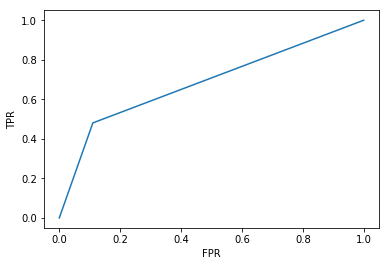

In [172]:
lr = LogisticRegression()
print_scores(lr, X_train, y_train, X_test, y_test)
plot_roc(lr, X_test, y_test)

/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/anaconda3/envs/mlib_demo/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Precision score: 0.758649
Recall score: 0.693367
F1 score: 0.707633
AUC score: 0.693367
Confusion Metric : [[1624  144]
 [ 468  412]]
Prediction Accuracy: 0.768882


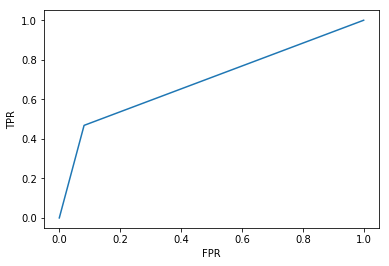

In [173]:
svc = SVC().fit(X_train, y_train)
print_scores(svc, X_train, y_train, X_test, y_test)
plot_roc(svc, X_test, y_test)